## Install Packages

## Import 

In [1]:
import sys
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, functional as TF
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import random_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Setup

In [2]:
## Unzip the data 

In [3]:
CURRENT_DIR = os.getcwd()
DATA_DIR = 'Test'
PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
print(PATH_TO_DATA)

/home/jovyan/classification/Test


In [4]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


In [5]:
train_data = datasets.FashionMNIST(
    root=PATH_TO_DATA, # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root=PATH_TO_DATA,
    train=False, # get test data
    download=True,
    transform=ToTensor()
)
class_names  = train_data.classes

In [6]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)

## Data augmentaion and normalizaion

In [7]:
# Create transform function
mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomRotation(45),
    transforms.RandomRotation(85),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])

transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes the image
    #transforms.CenterCrop((224, 224)),  # Crops the center of the resized image
    #transforms.Grayscale(num_output_channels=1),  # Converts the image to grayscale
    transforms.ToTensor(),  # Converts the image to a tensor
     transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)  # Normalizes the tensor image
])

data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

## Load Data

## Set up path for data after downloading

In [8]:
train_dataset = train_data
valid_dataset = test_data
img , label = train_dataset[0]
img.shape

#test_dir = f'{DATA_DIR}/test'

torch.Size([1, 28, 28])

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = TF.to_pil_image(image)
        if self.transform:
            image = self.transform(image)
        return image, label
train_dataset = CustomDataset(train_dataset, transform=transforms_train)
valid_dataset = CustomDataset(valid_dataset, transform=transforms_valid)   
# Create datasets with appropriate transformations

In [10]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [11]:
batch_size = 32
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {batch_size}")

Train dataset size: 60000
Valid dataset size: 10000
Class numbers: 10

Length of train dataloader: 1875 batches of 32
Length of valid dataloader: 313 batches of 32


#  Visualize data after transformation

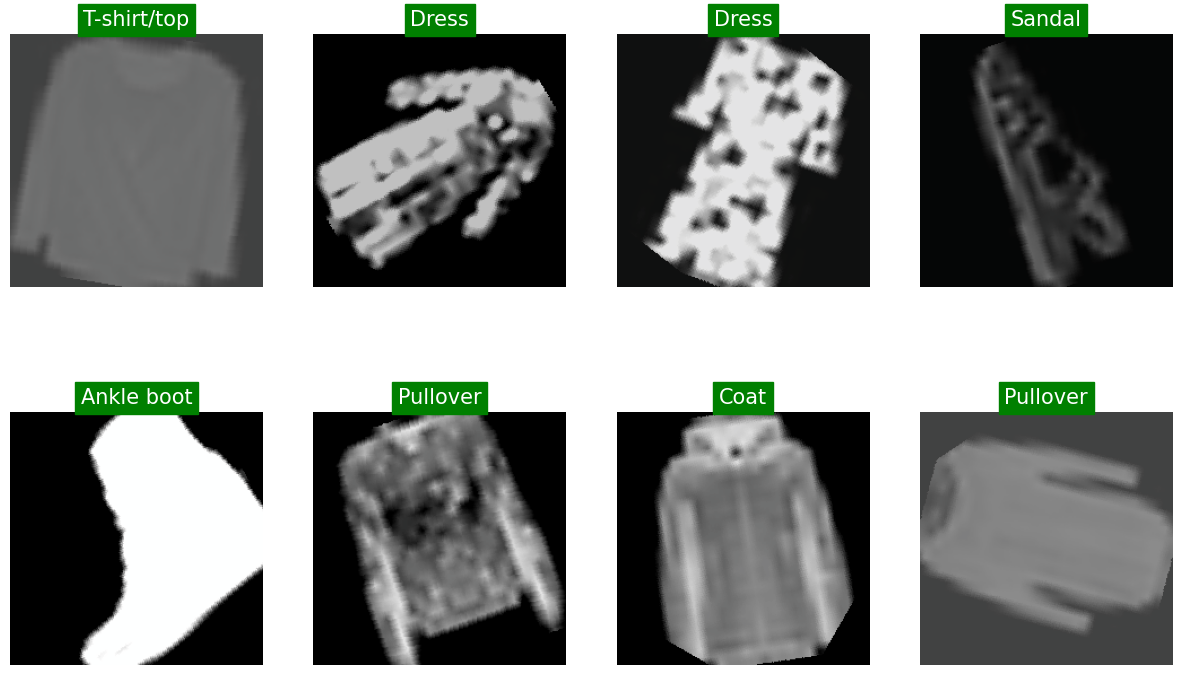

In [12]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)

def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [13]:
# Load the pre-trained ResNet-18 or 50 model
model = models.resnet50(pretrained=True) # resnet18 or resnet50?

# Freeze all layers with the final classification layer
#for param in model.parameters():
#    param.requires_grad = False
    
        
# Freeze earlier layers
# Let's say we decide to freeze all layers except the last 2 residual blocks and the fully connected layer
for name, child in model.named_children():
    if name in ['layer3','layer4', 'fc']:  # Unfreeze these layers #'layer4',
        for param in child.parameters():
            param.requires_grad = True
    else:  # Freeze these layers
        for param in child.parameters():
            param.requires_grad = False
            
# Parameters of newly constructed modules have requires_grad=True by default
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
lr = 0.0001
# I can use other optimizers like adam 
optimizer = optim.Adam(model.parameters(), lr=lr) # Use all parameters
# Optimizers to compare ##TODO
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=0.0001, momentum=0.9),
    'Adam': optim.Adam(model.parameters(), lr=0.0001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
}

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda:0


In [14]:
#train_loader = train_dataloader
#valid_loader = dataloaders['valid']

In [15]:
import datetime
import os
current_datetime = datetime.datetime.now()

# Extract the date, hour, and minute parts
current_date = current_datetime.date()
current_hour = current_datetime.hour
current_minute = current_datetime.minute
FILE_NAME = f'{current_date}_{current_hour}:{current_minute}'
current_exp_dir = f'Test/{FILE_NAME}'

In [16]:
def convert_to_three_channels(inputs):
    return inputs.repeat(1, 3, 1, 1) 

In [17]:
def train_model(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         device: torch.device=device):
    # training mode
    model.to(device)
    model.train()
    train_loss , train_corrects = 0  , 0
    y_pred = []
    y_true = []
        # loop through the training batches..
    for batch, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        optimizer.zero_grad()
            # forward inputs and get output
                # Convert inputs to 3 channels if they are not already
        if inputs.size(1) == 1:  # Check if the input channels = 1
            inputs = convert_to_three_channels(inputs)    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

            # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
            

        loss.backward()

        optimizer.step()

                # statistics
        train_loss += loss.item() 
        train_corrects += torch.sum(preds == labels.data).item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


        if batch % 100 == 0:
            print(f'Looked at {batch * len(inputs)}/{len(data_loader) * batch_size} samples.')
                

        #scheduler.step()    
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_corrects / len(data_loader.dataset) * 100
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    # Print progress
    print('.............')
    print('Train Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_train_loss, avg_train_acc, weighted_f1))
    return avg_train_loss, avg_train_acc, weighted_f1
    

In [18]:
def val_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              current_exp_dir: str, valid_ids,
              device: torch.device=device):
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
            # forward inputs and get output
                # Convert inputs to 3 channels if they are not already
        if inputs.size(1) == 1:  # Check if the input channels = 1
            inputs = convert_to_three_channels(inputs)  
        outputs = model(inputs)
        x, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)

        val_loss += loss.item() 
        val_corrects += torch.sum(preds == labels.data).item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(valid_ids)
    avg_valid_acc = val_corrects / len(valid_ids) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    print('Valid Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_valid_loss, avg_valid_acc, weighted_f1))

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]



In [19]:
dataset = train_data

## Train the model on custom data 

In [20]:
# Initialize best accuracy and initialize model weights
num_classes = len(class_names)

#batch_size = 32
num_epochs = 2
epochs = range(num_epochs)


best_acc =0.0

# train
epoch_train_loss=[]
train_accuracy=[]
train_weighted_f1=[]
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]

y_pred = []
y_true = []

fold_train_losses = []
fold_train_accuracies = []
fold_train_weighted_f1=[]
fold_valid_losses = []
fold_valid_accuracies = []
fold_valid_weighted_f1=[]

os.makedirs(current_exp_dir, exist_ok=True)
start_time = time.time()
# Start Training loop
with tqdm(total=len(epochs)*k_folds, file=sys.stdout) as pbar: 
    pbar.set_description('Processed:')
    for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(dataset)))):
        pbar.update(1)
        print()
        print(f'FOLD {fold+1}/{k_folds}')
        print('--------------------------------')
        train_subsampler = SubsetRandomSampler(train_ids)
        valid_subsampler = SubsetRandomSampler(valid_ids)
        print(f'Valid_dataset size: {len(valid_ids)}')

        # Create data loaders for training and validation
        train_dataset = CustomDataset(dataset, transform=transforms_train)
        valid_dataset = CustomDataset(dataset, transform=transforms_valid)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=4)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_subsampler, num_workers=4)
        print(len(train_dataloader.dataset))
        print(len(valid_dataloader.dataset))
        epoch_train_loss_2=[]
        train_accuracy_2=[]
        train_weighted_f1_2=[]
        # valid
        valid_loss_2=[]
        valid_accuracy_2=[]
        valid_weighted_f1_2 =[]
        
        for epoch in epochs:
                #print("Epoch {}/{} running....".format(epoch+1, num_epochs)) #(printing message)

            """ Training Phase """
            avg_train_loss, avg_train_acc, weighted_f1 = train_model(model, train_dataloader, loss_fn, optimizer,device)
                 # Append result
            epoch_train_loss.append(avg_train_loss)
            epoch_train_loss_2.append(avg_train_loss)
            train_accuracy.append(avg_train_acc)
            train_accuracy_2.append(avg_train_acc)
            train_weighted_f1.append(weighted_f1)
            train_weighted_f1_2.append(weighted_f1)
            


            """ Validation Phase """
            history = val_model(model, valid_dataloader, loss_fn, current_exp_dir,valid_ids , device)
                # Append result
            valid_loss.append(history[0])
            valid_loss_2.append(history[0])
            valid_accuracy.append(history[1])
            valid_accuracy_2.append(history[1])
            y_pred.extend(history[2])
            y_true.extend(history[3])
            valid_weighted_f1.append(history[4])
            valid_weighted_f1_2.append(history[4])
                                  # Save the best model
            if history[4] > best_acc:
                best_acc = history[4]
                torch.save(model.state_dict(), f'{current_exp_dir}/resnet_best.pth')
                print('Improvement-Detected, Best model updated')       
            print('.............')

            print()
            pbar.update(1)
            print()
        fold_train_losses.append(np.mean(epoch_train_loss_2))
        fold_train_accuracies.append(np.mean(train_accuracy_2))
        fold_valid_losses.append(np.mean(valid_loss_2))
        fold_valid_accuracies.append(np.mean(valid_accuracy_2))
        fold_train_weighted_f1.append(np.mean(train_weighted_f1_2))
        fold_valid_weighted_f1.append(np.mean(valid_weighted_f1_2))
    
torch.save(model.state_dict(), f'{current_exp_dir}/resnet_last.pth')
time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}%'.format(best_acc))

Processed::   0%|          | 0/10 [00:00<?, ?it/s]
FOLD 1/5
--------------------------------
Valid_dataset size: 12000
60000
60000
Looked at 0/48000 samples.
Looked at 3200/48000 samples.
Looked at 6400/48000 samples.
Looked at 9600/48000 samples.
Looked at 12800/48000 samples.
Looked at 16000/48000 samples.
Looked at 19200/48000 samples.
Looked at 22400/48000 samples.
Looked at 25600/48000 samples.
Looked at 28800/48000 samples.
Looked at 32000/48000 samples.
Looked at 35200/48000 samples.
Looked at 38400/48000 samples.
Looked at 41600/48000 samples.
Looked at 44800/48000 samples.
.............
Train Loss: 0.0129 | Acc: 65.2583% | Weighted F1: 81.4681
Valid Loss: 0.0107 | Acc: 87.5500% | Weighted F1: 87.0989
Improvement-Detected, Best model updated
.............

Processed::  20%|██        | 2/10 [03:41<14:44, 110.61s/it]
Looked at 0/48000 samples.
Looked at 3200/48000 samples.
Looked at 6400/48000 samples.
Looked at 9600/48000 samples.
Looked at 12800/48000 samples.
Looked at 16000/4

In [21]:
#summary(model, input_size=[12,3,224,224])

## Ploting

FileNotFoundError: [Errno 2] No such file or directory: 'models/2024-04-29_19:8/statistics-Epochs.png'

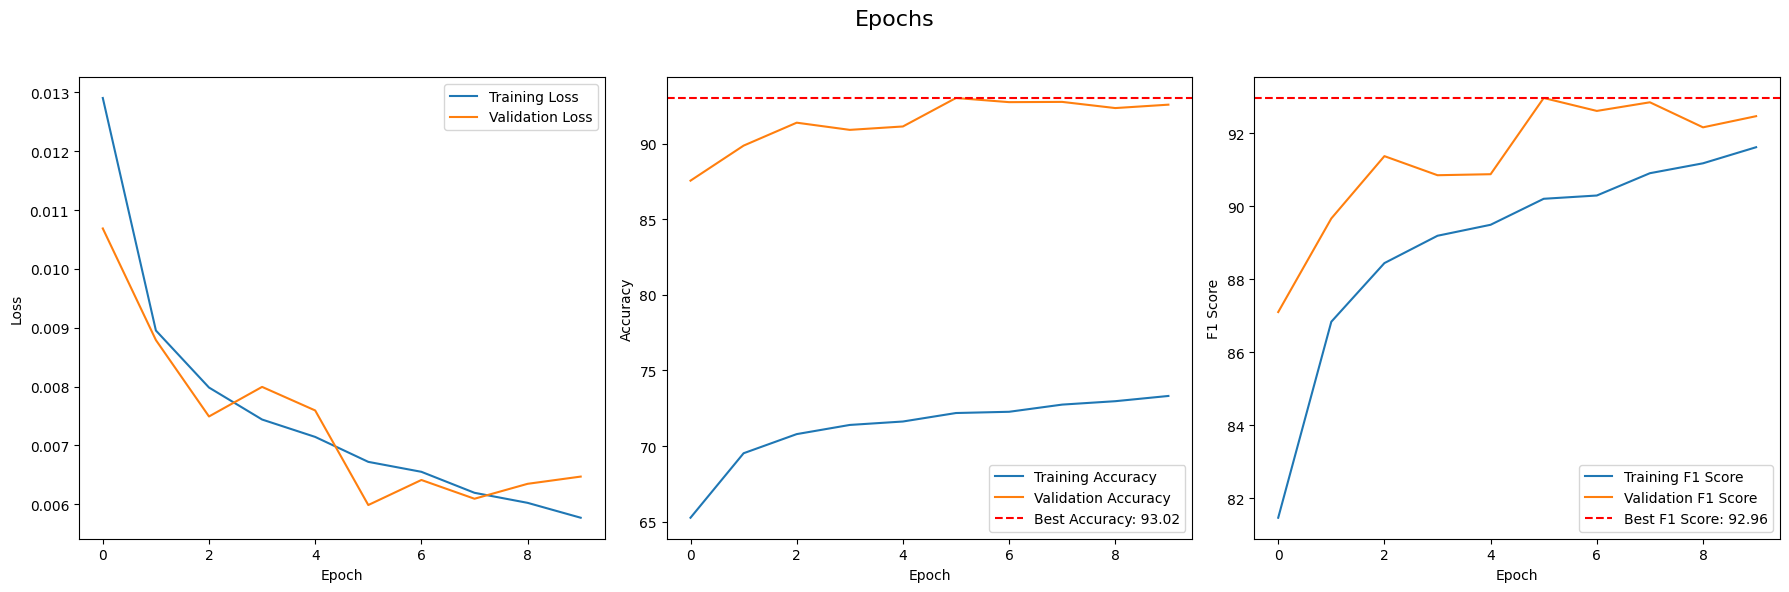

In [22]:
from utilities import visual
settings = { 'num_epochs': num_epochs, 'batch_size':batch_size,
            'criterion': 'CrossEntropyLoss', 
             'optimizer': 'Adam', 'lr': lr,
}
history = {
    'Training_Loss': epoch_train_loss,
    'Validation_Loss': valid_loss,
    'Training_Accuracy': train_accuracy,
    'Validation_Accuracy': valid_accuracy,
    'Training_F1_Score': train_weighted_f1,
     'Validation_F1_Score': valid_weighted_f1,
    'file_name': FILE_NAME,
}
title = 'Epochs'
visual.plot_results(history, title)

In [ ]:
import json
with open(f'{current_exp_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

FileNotFoundError: [Errno 2] No such file or directory: 'models/2024-04-29_19:8/statistics-Cross-Validation.png'

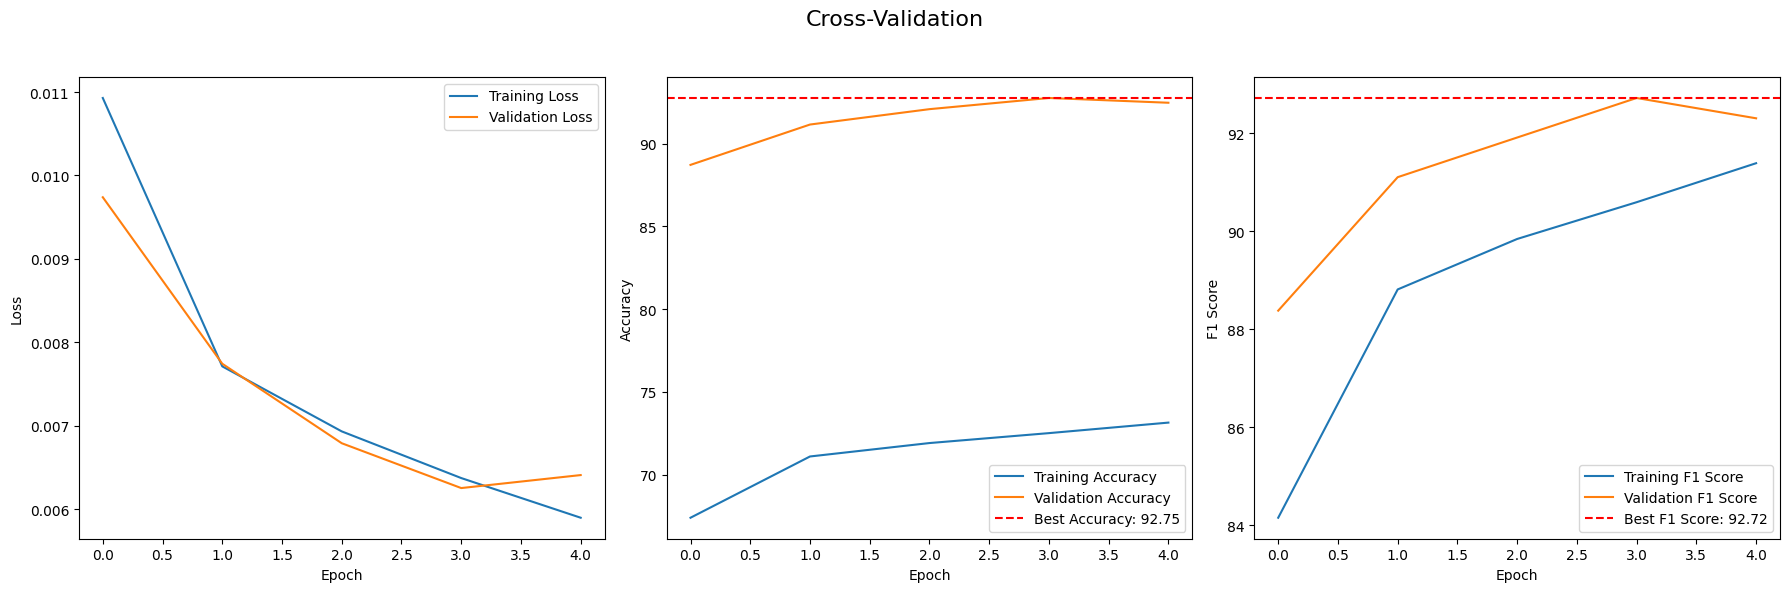

In [23]:
history_fold = {
    'Training_Loss': fold_train_losses,
    'Validation_Loss': fold_valid_losses,
    'Training_Accuracy': fold_train_accuracies,
    'Validation_Accuracy': fold_valid_accuracies,
    'Training_F1_Score': fold_train_weighted_f1,
     'Validation_F1_Score': fold_valid_weighted_f1,
    'file_name': FILE_NAME,
}
title = 'Cross-Validation'
visual.plot_results(history_fold, title)

Accuracy on Validation set:  0.9142833333333333
Confusion matrix: 
 [[10460     2   244   208    30     1   921     0   129     5]
 [    3 11834     4    84    23     5    12     0    33     2]
 [  110     1 10851    87   602     4   287     0    58     0]
 [  243    47    94 10817   473    15   251     3    56     1]
 [   14    11   525   288 10786     0   322     1    53     0]
 [    0     0     0     2     0 11688     0   251    11    48]
 [ 1216    13   892   229  1243     2  8135     0   270     0]
 [    0     0     0     0     0    51     0 11808     2   139]
 [    3     9    17    15    32     8     8     2 11902     4]
 [    0     6     0     0     1    75     2   475     8 11433]]
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     12000
           1       0.99      0.99      0.99     12000
           2       0.86      0.90      0.88     12000
           3       0.92      0.90      0.91     12000
     

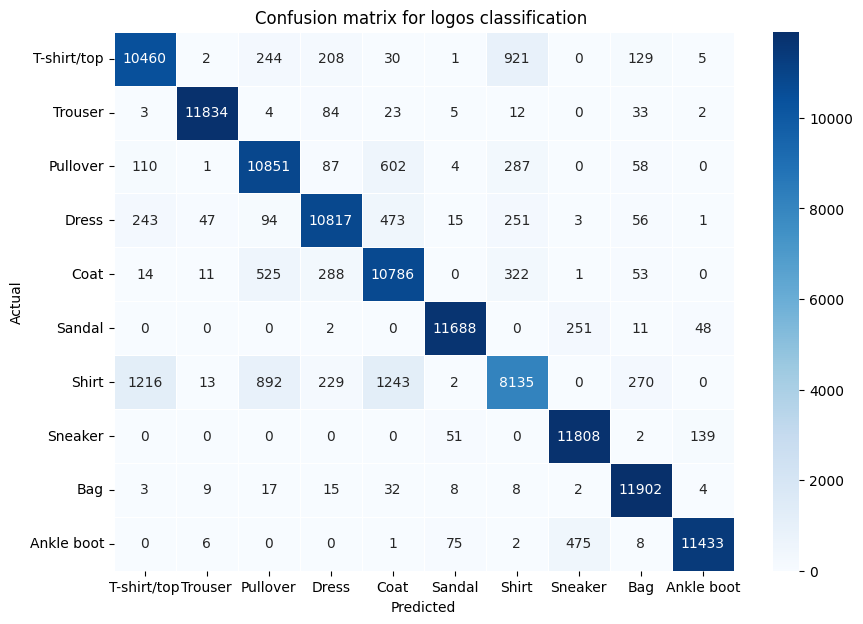

In [24]:
# constant for classes
# Build confusion matrix
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', linewidths=.5)
plt.title("Confusion matrix for logos classification ")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(f'{current_exp_dir}/Confusion_matrix.png')
plt.show()

In [ ]:
from torchmetrics import Accuracy
import numpy
accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
accuracy(preds, labels).item()*100
print(valid_accuary[-1])

# Load Saved Model

In [25]:
CURRENT_DIR = os.getcwd()
MODEL = 'Test/2024-04-29_17:27'
PATH_TO_MODEL =  os.path.join(CURRENT_DIR,MODEL)
print(PATH_TO_MODEL)

/home/jovyan/classification/Test/2024-04-29_17:27


In [26]:
import torch
from torchvision import models, transforms
from PIL import Image


# Load the saved model with custom class number
model = models.resnet50(pretrained=True) #resnet50
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

model.fc = nn.Linear(num_features, num_classes) # Adjust final layer to number of classes 

model.load_state_dict(torch.load(f'{PATH_TO_MODEL}/resnet_best.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

Number of features from pre-trained model 2048


### Get some images from the Dataset

### Evaluation 

## Clasification on unseen Image

In [27]:
# Load and preprocess the unseen image
image_path = 'img/yQqYbiYZaD-irOWSZcGb0-c6ae-0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [28]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Pullover


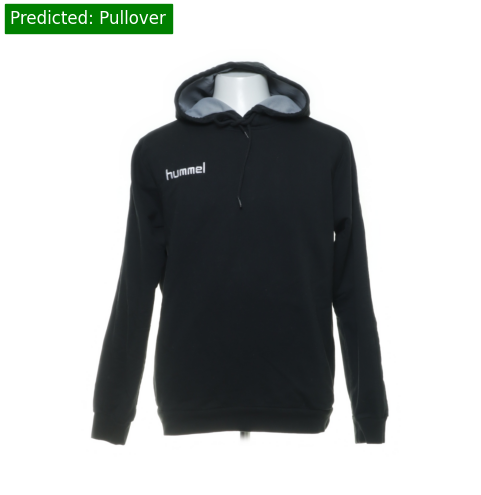

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()